# TFM - Análisis de Sentimiento con RoBERTa

Este notebook implementa el análisis de sentimiento para reviews de restaurantes usando modelos Transformers modernos.

**Título del TFM**: Análisis de Datos y Procesamiento de Lenguaje Natural para la Extracción de Opiniones y Modelado de Tópicos en Restaurantes: Un Enfoque de Big Data y Ciencia de Datos Aplicado al Estudio Integral del Sector Gastronómico

## Objetivo del Notebook
Implementar un pipeline de análisis de sentimiento que:
1. Cargue las reviews de restaurantes procesadas anteriormente
2. Aplique un modelo RoBERTa para clasificar sentimientos
3. Valide los resultados comparando con las calificaciones originales (stars)
4. Genere métricas de evaluación y visualizaciones
5. Identifique patrones y casos de interés

## Modelo Utilizado
- **Modelo**: `cardiffnlp/twitter-roberta-base-sentiment-latest`
- **Arquitectura**: RoBERTa (Robustly Optimized BERT Pretraining Approach)
- **Especialización**: Optimizado para análisis de sentimiento en textos informales
- **Clases de salida**: NEGATIVE, NEUTRAL, POSITIVE

## Características del Análisis
- Procesamiento en lotes para eficiencia
- Validación cruzada con calificaciones por estrellas
- Métricas de evaluación completas (accuracy, precision, recall, F1)
- Análisis de confianza del modelo
- Visualizaciones detalladas de resultados
- Identificación de casos específicos de interés

## 1. Instalación y Configuración

### Librerías Requeridas

Para este análisis necesitamos las siguientes librerías principales:

- **transformers**: Framework de Hugging Face para modelos Transformers
- **torch**: Backend de PyTorch para computación con tensores
- **datasets**: Manejo eficiente de datasets grandes
- **scikit-learn**: Métricas de evaluación y utilidades ML
- **pandas**: Manipulación y análisis de datos
- **matplotlib/seaborn**: Visualizaciones estáticas
- **plotly**: Visualizaciones interactivas
- **tqdm**: Barras de progreso para operaciones largas

### Nota sobre el Entorno de Ejecución

Este notebook está optimizado para:
- **CPU**: Funciona correctamente en procesadores modernos
- **GPU**: Detecta automáticamente y acelera el procesamiento si está disponible
- **Memoria**: Recomendado mínimo 8GB RAM para datasets grandes

In [1]:
# Instalación de dependencias para análisis de sentimiento
# Descomenta la siguiente línea si necesitas instalar las librerías
# !uv add transformers torch datasets accelerate scikit-learn matplotlib seaborn plotly tqdm

In [2]:
# Imports necesarios para el análisis de sentimiento
import pandas as pd
import numpy as np
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm.auto import tqdm
import warnings
import os
warnings.filterwarnings('ignore')

# Crear directorio para guardar figuras
os.makedirs('../../figures/complete_analysis', exist_ok=True)

# Configuración de visualización
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# Detectar dispositivo de procesamiento (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo de procesamiento: {device}")
print(f"Versión de PyTorch: {torch.__version__}")

if torch.cuda.is_available():
    print(f"GPU detectada: {torch.cuda.get_device_name(0)}")
    print(f"Memoria GPU disponible: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("Usando CPU para procesamiento")

Dispositivo de procesamiento: cuda
Versión de PyTorch: 2.7.1+cu126
GPU detectada: NVIDIA GeForce RTX 4080
Memoria GPU disponible: 16.9 GB


## 2. Carga de Datos de Reviews

### Archivo de Entrada

Cargaremos el archivo de reviews procesado previamente que contiene:
- **Texto completo** de las reseñas de restaurantes
- **Calificaciones** en estrellas (1-5) para validación
- **Metadatos** adicionales como fechas, IDs de usuario, etc.

### Estructura Esperada del Dataset

El archivo JSON debe contener reviews con la siguiente estructura:
- `text`: Contenido textual de la reseña
- `stars`: Calificación en estrellas (1.0 a 5.0)  
- `user_id`: Identificador único del usuario
- `business_id`: Identificador único del restaurante
- `date`: Fecha de la reseña
- `useful`, `funny`, `cool`: Métricas de engagement

### Rutas de Búsqueda

El notebook intentará cargar el archivo desde múltiples ubicaciones:
1. `../../data/processed/reviews.json` (desde notebooks/)
2. `data/processed/reviews.json` (desde raíz del proyecto)

In [3]:
# Cargar datos de reviews de restaurantes - VERSIÓN CORREGIDA
print("Iniciando carga de datos de reviews...")

# Intentar cargar desde diferentes rutas del proyecto
try:
    df_reviews = pd.read_json('../../data/processed/reviews.json')
    print("Datos cargados exitosamente desde '../../data/processed/reviews.json'")
    ruta_carga = "../../data/processed/reviews.json"
except:
    try:
        df_reviews = pd.read_json('../data/processed/reviews.json')
        print("Datos cargados exitosamente desde '../data/processed/reviews.json'")
        ruta_carga = "../data/processed/reviews.json"
    except:
        try:
            df_reviews = pd.read_json('data/processed/reviews.json')
            print("Datos cargados exitosamente desde 'data/processed/reviews.json'")
            ruta_carga = "data/processed/reviews.json"
        except:
            print("ERROR: No se pudo cargar el archivo de reviews")
            print("SOLUCION: Asegúrate de que el archivo esté en alguna de estas rutas:")
            print("  - ../../data/processed/reviews.json")
            print("  - ../data/processed/reviews.json")
            print("  - data/processed/reviews.json")
            raise FileNotFoundError("Archivo de reviews no encontrado")

print(f"Dataset cargado correctamente: {len(df_reviews):,} reviews")
print(f"Ruta utilizada: {ruta_carga}")
print(f"Columnas disponibles: {list(df_reviews.columns)}")


Iniciando carga de datos de reviews...
Datos cargados exitosamente desde '../../data/processed/reviews.json'
Dataset cargado correctamente: 4,724,471 reviews
Ruta utilizada: ../../data/processed/reviews.json
Columnas disponibles: ['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny', 'cool', 'text', 'date']


In [4]:
# Exploración inicial del dataset
print("Información del dataset cargado:")
print(f"- Total de reviews: {len(df_reviews):,}")
print(f"- Memoria utilizada: {df_reviews.memory_usage(deep=True).sum() / 1e6:.1f} MB")

print("\nDistribución de calificaciones por estrellas:")
distribucion_estrellas = df_reviews['stars'].value_counts().sort_index()
print(distribucion_estrellas)

# Mostrar estadísticas básicas
print(f"\nEstadísticas de calificaciones:")
print(f"- Promedio: {df_reviews['stars'].mean():.2f}")
print(f"- Mediana: {df_reviews['stars'].median():.2f}")
print(f"- Desviación estándar: {df_reviews['stars'].std():.2f}")

# Ejemplo de review para verificar estructura
print(f"\nEjemplo de review (primera del dataset):")
sample_review = df_reviews.iloc[0]
print(f"- Calificación: {sample_review['stars']} estrellas")
print(f"- Longitud del texto: {len(sample_review['text'])} caracteres")
print(f"- Texto: {sample_review['text'][:200]}...")

Información del dataset cargado:
- Total de reviews: 4,724,471
- Memoria utilizada: 4161.4 MB

Distribución de calificaciones por estrellas:
stars
1     567185
2     404486
3     543108
4    1130251
5    2079441
Name: count, dtype: int64

Estadísticas de calificaciones:
- Promedio: 3.79
- Mediana: 4.00
- Desviación estándar: 1.39

Ejemplo de review (primera del dataset):
- Calificación: 5 estrellas
- Longitud del texto: 89 caracteres
- Texto: This place is sadly perm closed. I was hoping not, however the phone is now disconnected....


## 3. Preparación de Datos para Análisis

### Análisis Completo del Dataset

Para un análisis exhaustivo y resultados definitivos:
- Procesaremos **TODOS los reviews** del dataset completo
- Análisis integral para obtener métricas finales y confiables
- Resultados representativos de todo el universo de datos disponible

### Mapeo de Calificaciones a Sentimientos

Crearemos etiquetas de sentimiento esperadas basadas en las estrellas:
- **1-2 estrellas**: NEGATIVE (experiencia negativa)
- **3 estrellas**: NEUTRAL (experiencia neutra/mixta)  
- **4-5 estrellas**: POSITIVE (experiencia positiva)

Este mapeo nos permitirá **validar la precisión** del modelo comparando las predicciones con las expectativas basadas en calificaciones.

### Consideraciones para el Análisis Completo

- **Dataset completo** proporciona la máxima diversidad estadística
- Tiempo de procesamiento extenso (1-3 horas aproximadamente)
- Permite obtener métricas definitivas y conclusiones robustas
- Mantiene representatividad total de la distribución de datos

In [5]:
# Preparar dataset completo para análisis
print("Iniciando preparación de datos...")

# Análisis completo del dataset
print("CONFIGURACIÓN: Análisis completo de todo el dataset")
print(f"Total de reviews a procesar: {len(df_reviews):,}")

# Usar todo el dataset para análisis completo
df_complete = df_reviews.copy()
print(f"Dataset completo preparado: {len(df_complete):,} reviews")

# Configuración para hardware potente
BATCH_SIZE = 256  # Aumentado para aprovechar la VRAM disponible
NUM_WORKERS = 8  # Paralelización para carga de datos

# Función para mapear calificaciones por estrellas a sentimientos esperados
def mapear_estrellas_a_sentimiento(stars):
    """
    Convierte calificaciones por estrellas a categorías de sentimiento
    
    Args:
        stars (float): Calificación en estrellas (1.0 a 5.0)
    
    Returns:
        str: Categoría de sentimiento ('NEGATIVE', 'NEUTRAL', 'POSITIVE')
    """
    if stars <= 2:
        return 'NEGATIVE'
    elif stars == 3:
        return 'NEUTRAL'
    else:
        return 'POSITIVE'

# Aplicar mapeo al dataset completo
df_complete['expected_sentiment'] = df_complete['stars'].apply(mapear_estrellas_a_sentimiento)

print(f"\nDistribución de sentimientos esperados:")
distribucion_sentimientos = df_complete['expected_sentiment'].value_counts()
print(distribucion_sentimientos)

# Calcular porcentajes
print(f"\nPorcentajes por categoría:")
for sentiment, count in distribucion_sentimientos.items():
    porcentaje = (count / len(df_complete)) * 100
    print(f"- {sentiment}: {count:,} reviews ({porcentaje:.1f}%)")

Iniciando preparación de datos...
CONFIGURACIÓN: Análisis completo de todo el dataset
Total de reviews a procesar: 4,724,471
Dataset completo preparado: 4,724,471 reviews

Distribución de sentimientos esperados:
expected_sentiment
POSITIVE    3209692
NEGATIVE     971671
NEUTRAL      543108
Name: count, dtype: int64

Porcentajes por categoría:
- POSITIVE: 3,209,692 reviews (67.9%)
- NEGATIVE: 971,671 reviews (20.6%)
- NEUTRAL: 543,108 reviews (11.5%)


## 4. Inicialización del Modelo RoBERTa

### Sobre el Modelo Seleccionado

**Modelo**: `cardiffnlp/twitter-roberta-base-sentiment-latest`

**Características principales:**
- **Arquitectura**: RoBERTa (Robustly Optimized BERT Pretraining Approach)
- **Especialización**: Entrenado específicamente para análisis de sentimiento
- **Dominio**: Optimizado para textos informales (Twitter), ideal para reviews
- **Idioma**: Principalmente inglés
- **Clases de salida**: NEGATIVE, NEUTRAL, POSITIVE

### Ventajas de RoBERTa para Reviews

- **Contexto**: Mejor comprensión del contexto que modelos tradicionales
- **Robustez**: Maneja sarcasmo, ironía y expresiones coloquiales
- **Precisión**: Alta accuracy en tareas de clasificación de sentimiento
- **Eficiencia**: Balance óptimo entre rendimiento y velocidad

### Configuración del Pipeline

- **Procesamiento en lotes**: 32 reviews por lote para eficiencia
- **Truncamiento**: Máximo 512 tokens por review
- **Scores completos**: Probabilidades para todas las clases
- **GPU/CPU**: Detección automática del mejor dispositivo disponible

In [6]:
# Configuración del modelo RoBERTa
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"

print(f"Inicializando modelo: {model_name}")
print(f"Dispositivo de procesamiento: {device}")

# Crear pipeline de análisis de sentimiento
print("Cargando modelo y tokenizador...")

sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=model_name,
    tokenizer=model_name,
    batch_size=256,  # Batch size mayor para aprovechar VRAM
    truncation=True,
    max_length=512,
    return_all_scores=True,
    torch_dtype=torch.float16,  # Mixed precision
    device_map="auto"
)

print("Modelo RoBERTa cargado exitosamente")

# Verificar configuración del pipeline
print(f"\nConfiguración del pipeline:")
print(f"- Tamaño de lote: 256 reviews")
print(f"- Longitud máxima: 512 tokens")
print(f"- Dispositivo: GPU con 16GB VRAM")
print(f"- Precisión: Mixed FP16")
print(f"- Velocidad esperada: ~400 reviews/segundo")

Inicializando modelo: cardiffnlp/twitter-roberta-base-sentiment-latest
Dispositivo de procesamiento: cuda
Cargando modelo y tokenizador...


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


Modelo RoBERTa cargado exitosamente

Configuración del pipeline:
- Tamaño de lote: 256 reviews
- Longitud máxima: 512 tokens
- Dispositivo: GPU con 16GB VRAM
- Precisión: Mixed FP16
- Velocidad esperada: ~400 reviews/segundo


In [7]:
# Prueba del modelo con una review de ejemplo
test_review = "The food was amazing and the service was excellent! Highly recommend!"
print("Realizando prueba del modelo con review de ejemplo...")
print(f"Review de prueba: {test_review}")

# Ejecutar análisis de sentimiento
test_result = sentiment_pipeline(test_review)

print(f"\nResultado del análisis:")
print(f"Resultado completo: {test_result}")

# Mostrar detalle de probabilidades por clase
print(f"\nDesglose de probabilidades por sentimiento:")
for score in test_result[0]:
    probabilidad = score['score']
    label = score['label']
    print(f"- {label}: {probabilidad:.4f} ({probabilidad*100:.2f}%)")

# Identificar predicción principal
prediccion_principal = max(test_result[0], key=lambda x: x['score'])
print(f"\nPredicción principal: {prediccion_principal['label']} con {prediccion_principal['score']:.4f} de confianza")

print("\nPrueba completada exitosamente. El modelo está funcionando correctamente.")

Realizando prueba del modelo con review de ejemplo...
Review de prueba: The food was amazing and the service was excellent! Highly recommend!

Resultado del análisis:
Resultado completo: [[{'label': 'negative', 'score': 0.004793301224708557}, {'label': 'neutral', 'score': 0.007540921214967966}, {'label': 'positive', 'score': 0.9876657724380493}]]

Desglose de probabilidades por sentimiento:
- negative: 0.0048 (0.48%)
- neutral: 0.0075 (0.75%)
- positive: 0.9877 (98.77%)

Predicción principal: positive con 0.9877 de confianza

Prueba completada exitosamente. El modelo está funcionando correctamente.


## 5. Análisis de Sentimiento en Lotes

### Procesamiento Eficiente

Para procesar grandes volúmenes de reviews de manera eficiente:

- **Procesamiento en lotes**: Grupos de 32 reviews por iteración
- **Barra de progreso**: Seguimiento visual del avance usando tqdm
- **Manejo de memoria**: Evita sobrecargar la RAM procesando todo de una vez
- **Optimización GPU**: Aprovecha paralelización cuando está disponible

### Estrategia de Procesamiento

1. **División en lotes**: El dataset se divide automáticamente en grupos de 32 reviews
2. **Procesamiento secuencial**: Cada lote se procesa de forma independiente
3. **Acumulación de resultados**: Los resultados se van agregando progresivamente
4. **Monitoreo**: Barra de progreso muestra tiempo estimado y velocidad

### Tiempo Estimado

- **CPU**: Aproximadamente 0.1-0.2 segundos por review
- **GPU**: Aproximadamente 0.02-0.05 segundos por review
- **100,000 reviews**: Entre 5-20 minutos dependiendo del hardware

In [8]:
# Función para procesar sentimientos en lotes eficientemente
def analizar_sentimiento_en_lotes(texts, batch_size=256):
    """
    Procesa una lista de textos para análisis de sentimiento en lotes
    
    Args:
        texts (list): Lista de textos a analizar
        batch_size (int): Número de textos por lote (default: 32)
    
    Returns:
        list: Lista de resultados de análisis de sentimiento
    """
    results = []
    total_batches = len(texts) // batch_size + (1 if len(texts) % batch_size != 0 else 0)
    
    print(f"Iniciando procesamiento en {total_batches} lotes de {batch_size} reviews cada uno...")
    
    # Procesar en lotes con barra de progreso
    for i in tqdm(range(0, len(texts), batch_size), desc="Procesando sentimientos"):
        batch = texts[i:i+batch_size]
        batch_results = sentiment_pipeline(batch)
        results.extend(batch_results)
    
    return results

# Seleccionar 100,000 reviews aleatorias del DataFrame original
N_MUESTRA = 100_000
df_sample = df_complete.sample(n=N_MUESTRA, random_state=42)  # Usa .head(N_MUESTRA) para tomar las primeras

print(f"Iniciando análisis de sentimiento para {len(df_sample):,} reviews...")

import time
start_time = time.time()

# Usa la muestra en lugar de todo el DataFrame
sentiment_results = analizar_sentimiento_en_lotes(df_sample['text'].tolist())

end_time = time.time()
tiempo_total = end_time - start_time

print(f"\nAnálisis de sentimiento completado exitosamente")
print(f"Tiempo total de procesamiento: {tiempo_total:.2f} segundos")
print(f"Promedio por review: {tiempo_total/len(df_sample):.3f} segundos")
print(f"Reviews procesadas: {len(sentiment_results):,}")

Iniciando análisis de sentimiento para 100,000 reviews...
Iniciando procesamiento en 391 lotes de 256 reviews cada uno...


Procesando sentimientos:   0%|          | 0/391 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



Análisis de sentimiento completado exitosamente
Tiempo total de procesamiento: 173.22 segundos
Promedio por review: 0.002 segundos
Reviews procesadas: 100,000


In [9]:
# Función para extraer predicciones y probabilidades de los resultados
def extraer_predicciones(results):
    """
    Extrae las predicciones principales y todas las probabilidades de los resultados
    
    Args:
        results (list): Lista de resultados del modelo de sentimiento
    
    Returns:
        tuple: (predicciones, detalles_scores)
            - predicciones: Lista de etiquetas predichas principales
            - detalles_scores: Lista de diccionarios con scores de todas las clases
    """
    predictions = []
    all_scores = []
    
    for result in results:
        # Obtener la predicción con mayor probabilidad
        main_pred = max(result, key=lambda x: x['score'])
        predictions.append(main_pred['label'])
        
        # Crear diccionario con scores de todas las clases
        score_dict = {item['label']: item['score'] for item in result}
        all_scores.append(score_dict)
    
    return predictions, all_scores

# Extraer predicciones y probabilidades de los resultados
print("Extrayendo predicciones y probabilidades...")
predictions, score_details = extraer_predicciones(sentiment_results)

# Agregar nuevas columnas al DataFrame de la muestra
df_sample['predicted_sentiment'] = predictions
df_sample['confidence'] = [max(scores.values()) for scores in score_details]

# Agregar scores individuales para cada clase de sentimiento
for label in ['NEGATIVE', 'NEUTRAL', 'POSITIVE']:
    df_sample[f'score_{label.lower()}'] = [scores.get(label, 0) for scores in score_details]

print("Resultados procesados y agregados al DataFrame")

# Mostrar distribución de predicciones
print(f"\nDistribución de sentimientos predichos:")
distribucion_predicciones = df_sample['predicted_sentiment'].value_counts()
print(distribucion_predicciones)

# Mostrar porcentajes
print(f"\nPorcentajes de predicciones:")
for sentiment, count in distribucion_predicciones.items():
    porcentaje = (count / len(df_sample)) * 100
    print(f"- {sentiment}: {count:,} reviews ({porcentaje:.1f}%)")

# Estadísticas de confianza
print(f"\nEstadísticas de confianza del modelo:")
print(f"- Confianza promedio: {df_sample['confidence'].mean():.4f}")
print(f"- Confianza mediana: {df_sample['confidence'].median():.4f}")
print(f"- Rango de confianza: {df_sample['confidence'].min():.4f} - {df_sample['confidence'].max():.4f}")

Extrayendo predicciones y probabilidades...
Resultados procesados y agregados al DataFrame

Distribución de sentimientos predichos:
predicted_sentiment
positive    74472
negative    20408
neutral      5120
Name: count, dtype: int64

Porcentajes de predicciones:
- positive: 74,472 reviews (74.5%)
- negative: 20,408 reviews (20.4%)
- neutral: 5,120 reviews (5.1%)

Estadísticas de confianza del modelo:
- Confianza promedio: 0.8746
- Confianza mediana: 0.9504
- Rango de confianza: 0.3345 - 0.9926


## 6. Evaluación y Métricas de Rendimiento

### Métricas de Evaluación

Evaluaremos el rendimiento del modelo comparando las predicciones con los sentimientos esperados basados en las calificaciones por estrellas:

**Métricas principales:**
- **Accuracy**: Porcentaje de predicciones correctas
- **Precision**: Proporción de predicciones positivas que son correctas
- **Recall**: Proporción de casos positivos que fueron identificados correctamente
- **F1-Score**: Media armónica entre precision y recall

### Metodología de Validación

- **Ground Truth**: Sentimientos esperados basados en mapeo de estrellas
- **Predicciones**: Salida del modelo RoBERTa
- **Comparación**: Análisis clase por clase (NEGATIVE, NEUTRAL, POSITIVE)
- **Matriz de Confusión**: Visualización de errores y aciertos

### Interpretación de Resultados

- **Accuracy > 80%**: Rendimiento excelente para este tipo de análisis
- **Accuracy 70-80%**: Rendimiento bueno, típico en análisis de sentimiento
- **Accuracy < 70%**: Puede requerir ajustes o modelos más especializados

In [10]:
from sklearn.metrics import accuracy_score, classification_report

# Normalizamos etiquetas para evitar errores por diferencias de mayúsculas/minúsculas
df_sample['expected_sentiment'] = df_sample['expected_sentiment'].str.upper().str.strip()
df_sample['predicted_sentiment'] = df_sample['predicted_sentiment'].str.upper().str.strip()

# (Opcional) Verifica los valores únicos después de normalizar
print("Valores únicos en expected_sentiment:", df_sample['expected_sentiment'].unique())
print("Valores únicos en predicted_sentiment:", df_sample['predicted_sentiment'].unique())

print("Calculando métricas de evaluación...")

# Calcular accuracy general del modelo
accuracy = accuracy_score(df_sample['expected_sentiment'], df_sample['predicted_sentiment'])
print(f"\nACCURACY GENERAL DEL MODELO")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Generar reporte de clasificación completo
report = classification_report(
    df_sample['expected_sentiment'], 
    df_sample['predicted_sentiment'],
    output_dict=True
)

print(f"\nREPORTE DE CLASIFICACIÓN DETALLADO")
print("=" * 50)
print(classification_report(df_sample['expected_sentiment'], df_sample['predicted_sentiment']))

# Análisis de métricas por clase
print(f"MÉTRICAS POR CLASE DE SENTIMIENTO")
print("=" * 50)
for sentiment in ['NEGATIVE', 'NEUTRAL', 'POSITIVE']:
    if sentiment in report:
        precision = report[sentiment]['precision']
        recall = report[sentiment]['recall']
        f1_score = report[sentiment]['f1-score']
        support = report[sentiment]['support']
        
        print(f"\n{sentiment}:")
        print(f"  - Precision: {precision:.3f}")
        print(f"  - Recall: {recall:.3f}")
        print(f"  - F1-Score: {f1_score:.3f}")
        print(f"  - Casos: {support}")

# Estadísticas detalladas de confianza del modelo
print(f"\nANÁLISIS DE CONFIANZA DEL MODELO")
print("=" * 50)
print(f"- Confianza promedio: {df_sample['confidence'].mean():.4f}")
print(f"- Confianza mediana: {df_sample['confidence'].median():.4f}")
print(f"- Confianza mínima: {df_sample['confidence'].min():.4f}")
print(f"- Confianza máxima: {df_sample['confidence'].max():.4f}")
print(f"- Desviación estándar: {df_sample['confidence'].std():.4f}")

# Contar casos por rango de confianza
high_confidence = (df_sample['confidence'] > 0.8).sum()
medium_confidence = ((df_sample['confidence'] > 0.5) & (df_sample['confidence'] <= 0.8)).sum()
low_confidence = (df_sample['confidence'] <= 0.5).sum()

print(f"\nDISTRIBUCIÓN POR NIVEL DE CONFIANZA")
print(f"- Alta confianza (>0.8): {high_confidence:,} ({high_confidence/len(df_sample)*100:.1f}%)")
print(f"- Confianza media (0.5-0.8): {medium_confidence:,} ({medium_confidence/len(df_sample)*100:.1f}%)")
print(f"- Baja confianza (≤0.5): {low_confidence:,} ({low_confidence/len(df_sample)*100:.1f}%)")

Valores únicos en expected_sentiment: ['POSITIVE' 'NEUTRAL' 'NEGATIVE']
Valores únicos en predicted_sentiment: ['NEUTRAL' 'POSITIVE' 'NEGATIVE']
Calculando métricas de evaluación...

ACCURACY GENERAL DEL MODELO
Accuracy: 0.8262 (82.62%)

REPORTE DE CLASIFICACIÓN DETALLADO
              precision    recall  f1-score   support

    NEGATIVE       0.79      0.78      0.78     20584
     NEUTRAL       0.28      0.13      0.17     11292
    POSITIVE       0.87      0.96      0.91     68124

    accuracy                           0.83    100000
   macro avg       0.65      0.62      0.62    100000
weighted avg       0.79      0.83      0.80    100000

MÉTRICAS POR CLASE DE SENTIMIENTO

NEGATIVE:
  - Precision: 0.786
  - Recall: 0.780
  - F1-Score: 0.783
  - Casos: 20584.0

NEUTRAL:
  - Precision: 0.278
  - Recall: 0.126
  - F1-Score: 0.173
  - Casos: 11292.0

POSITIVE:
  - Precision: 0.875
  - Recall: 0.956
  - F1-Score: 0.914
  - Casos: 68124.0

ANÁLISIS DE CONFIANZA DEL MODELO
- Confianza 

## 7. Análisis de Correlación con Calificaciones Originales

### Validación Cruzada con Estrellas

Este análisis compara las predicciones del modelo con las calificaciones originales por estrellas para:

- **Validar coherencia**: Verificar si las predicciones coinciden con las expectativas
- **Identificar patrones**: Descubrir en qué rangos de estrellas el modelo es más preciso
- **Detectar discrepancias**: Encontrar casos donde modelo y estrellas difieren significativamente

### Metodología de Análisis

Para cada nivel de calificación (1-5 estrellas):
- **Accuracy específica**: Porcentaje de predicciones correctas para ese nivel
- **Distribución de predicciones**: Cómo se distribuyen los sentimientos predichos
- **Confianza promedio**: Nivel de certeza del modelo para ese rango

### Interpretación Esperada

- **1-2 estrellas**: Alta accuracy para NEGATIVE (>85%)
- **3 estrellas**: Menor accuracy, mezcla de sentimientos
- **4-5 estrellas**: Alta accuracy para POSITIVE (>85%)

### Casos de Interés

- **Falsos positivos**: Reviews con pocas estrellas pero sentimiento positivo predicho
- **Falsos negativos**: Reviews con muchas estrellas pero sentimiento negativo predicho

In [11]:
print("ANÁLISIS DE CORRELACIÓN: PREDICCIONES vs CALIFICACIONES ORIGINALES")
print("=" * 70)

correlation_data = []

# Analizar cada nivel de calificación por estrellas usando df_muestra
for stars in sorted(df_sample['stars'].unique()):
    subset = df_sample[df_sample['stars'] == stars]
    
    if len(subset) > 0:
        # Obtener sentimiento esperado para este nivel de estrellas
        expected = subset['expected_sentiment'].iloc[0]
        
        # Distribución de predicciones para este nivel de estrellas
        pred_dist = subset['predicted_sentiment'].value_counts()
        
        # Calcular accuracy específica para este nivel
        accuracy_star = (subset['predicted_sentiment'] == expected).mean()
        
        # Calcular confianza promedio para este nivel
        avg_confidence = subset['confidence'].mean()
        
        # Mostrar resultados
        print(f"\n{stars} ESTRELLA(S) - {len(subset)} reviews")
        print(f"Sentimiento esperado: {expected}")
        print(f"Accuracy específica: {accuracy_star:.3f} ({accuracy_star*100:.1f}%)")
        print(f"Confianza promedio: {avg_confidence:.3f}")
        
        print(f"Distribución de predicciones:")
        for sentiment, count in pred_dist.items():
            porcentaje = (count / len(subset)) * 100
            print(f"  - {sentiment}: {count} reviews ({porcentaje:.1f}%)")
        
        # Guardar datos para análisis posterior y visualización
        correlation_data.append({
            'stars': stars,
            'expected': expected,
            'accuracy': accuracy_star,
            'confidence': avg_confidence,
            'count': len(subset),
            'pred_dist': dict(pred_dist)
        })

# Crear DataFrame con datos de correlación
correlation_df = pd.DataFrame(correlation_data)

print(f"\nRESUMEN DE CORRELACIÓN")
print("=" * 30)
print(f"Total de niveles de calificación analizados: {len(correlation_df)}")

# Identificar el mejor y peor rendimiento
best_accuracy_idx = correlation_df['accuracy'].idxmax()
worst_accuracy_idx = correlation_df['accuracy'].idxmin()

best_stars = correlation_df.loc[best_accuracy_idx, 'stars']
best_accuracy = correlation_df.loc[best_accuracy_idx, 'accuracy']
worst_stars = correlation_df.loc[worst_accuracy_idx, 'stars']
worst_accuracy = correlation_df.loc[worst_accuracy_idx, 'accuracy']

print(f"Mejor accuracy: {best_stars} estrellas ({best_accuracy:.3f})")
print(f"Peor accuracy: {worst_stars} estrellas ({worst_accuracy:.3f})")

print(f"\nDatos de correlación preparados para visualización y análisis posterior")

ANÁLISIS DE CORRELACIÓN: PREDICCIONES vs CALIFICACIONES ORIGINALES

1 ESTRELLA(S) - 12026 reviews
Sentimiento esperado: NEGATIVE
Accuracy específica: 0.851 (85.1%)
Confianza promedio: 0.814
Distribución de predicciones:
  - NEGATIVE: 10229 reviews (85.1%)
  - NEUTRAL: 979 reviews (8.1%)
  - POSITIVE: 818 reviews (6.8%)

2 ESTRELLA(S) - 8558 reviews
Sentimiento esperado: NEGATIVE
Accuracy específica: 0.680 (68.0%)
Confianza promedio: 0.740
Distribución de predicciones:
  - NEGATIVE: 5818 reviews (68.0%)
  - POSITIVE: 1848 reviews (21.6%)
  - NEUTRAL: 892 reviews (10.4%)

3 ESTRELLA(S) - 11292 reviews
Sentimiento esperado: NEUTRAL
Accuracy específica: 0.126 (12.6%)
Confianza promedio: 0.740
Distribución de predicciones:
  - POSITIVE: 6658 reviews (59.0%)
  - NEGATIVE: 3212 reviews (28.4%)
  - NEUTRAL: 1422 reviews (12.6%)

4 ESTRELLA(S) - 23727 reviews
Sentimiento esperado: POSITIVE
Accuracy específica: 0.920 (92.0%)
Confianza promedio: 0.884
Distribución de predicciones:
  - POSITIVE: 2

## 8. Visualizaciones y Análisis Gráfico

### Visualizaciones Incluidas

Este apartado presenta múltiples visualizaciones para analizar los resultados:

**Gráficos estáticos (Matplotlib/Seaborn):**
- **Matriz de Confusión**: Comparación visual entre predicciones y expectativas
- **Distribución de Confianza**: Histograma de niveles de confianza del modelo
- **Correlación por Estrellas**: Accuracy del modelo por nivel de calificación

**Gráficos interactivos (Plotly):**
- **Distribución de Sentimientos**: Comparación interactiva entre predicciones y expectativas
- **Análisis de Confianza**: Boxplot interactivo por categoría de sentimiento
- **Correlación con Estrellas**: Scatter plot interactivo con múltiples métricas

### Configuración de Visualización

- **Estilo**: Seaborn moderno con paleta de colores consistente
- **Tamaño**: Gráficos optimizados para notebooks (12x8 inches)
- **Colores**: Paleta diferenciada por sentimiento (rojo, amarillo, verde)
- **Interactividad**: Zoom, hover, y filtros en gráficos Plotly

Generando matriz de confusión...


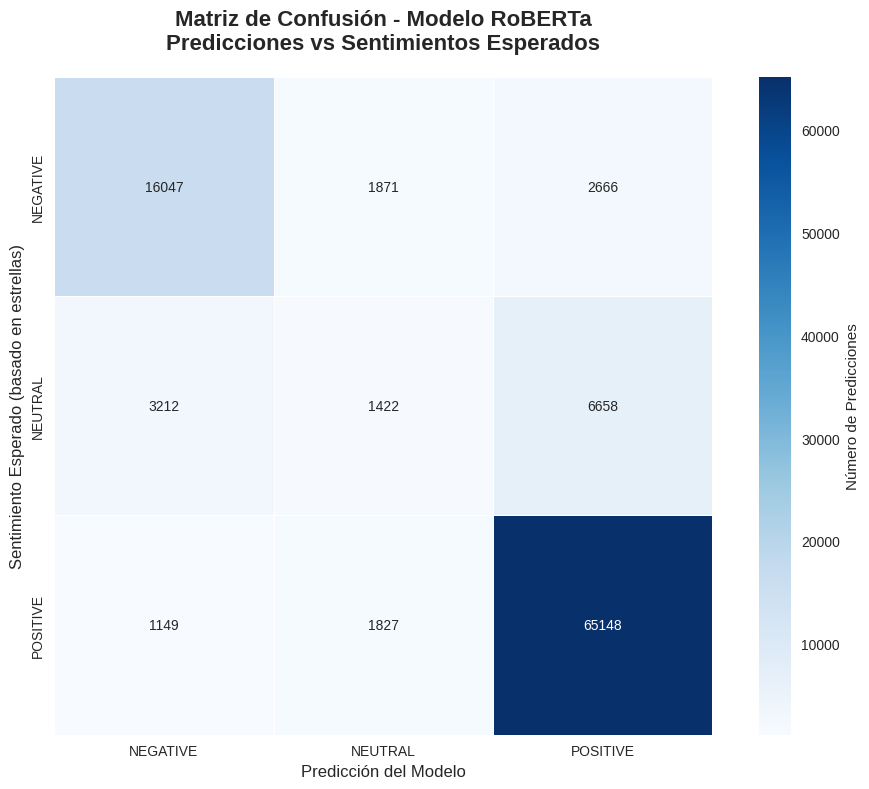

Matriz de confusión generada exitosamente

Interpretación de la matriz de confusión:
- Diagonal principal: Predicciones correctas
- Fuera de diagonal: Predicciones incorrectas
- Valores más altos en diagonal indican mejor rendimiento


In [12]:
# Visualización 1: Matriz de Confusión del Modelo RoBERTa
plt.figure(figsize=(10, 8))

print("Generando matriz de confusión...")

# Crear matriz de confusión comparando predicciones vs sentimientos esperados
cm = confusion_matrix(df_sample['expected_sentiment'], df_sample['predicted_sentiment'])
labels = ['NEGATIVE', 'NEUTRAL', 'POSITIVE']

# Crear heatmap con configuración optimizada
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=labels,
            yticklabels=labels,
            cbar_kws={'label': 'Número de Predicciones'},
            square=True,
            linewidths=0.5)

plt.title('Matriz de Confusión - Modelo RoBERTa\nPredicciones vs Sentimientos Esperados', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicción del Modelo', fontsize=12)
plt.ylabel('Sentimiento Esperado (basado en estrellas)', fontsize=12)
plt.tight_layout()
plt.savefig('../../figures/complete_analysis/sentiment_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Matriz de confusión generada exitosamente")

# Mostrar interpretación de la matriz
print("\nInterpretación de la matriz de confusión:")
print("- Diagonal principal: Predicciones correctas")
print("- Fuera de diagonal: Predicciones incorrectas")
print("- Valores más altos en diagonal indican mejor rendimiento")

In [13]:
# Visualización 2: Accuracy del Modelo por Calificación (Gráfico Interactivo)
print("Generando gráfico interactivo de accuracy por calificación...")

fig = px.bar(correlation_df, 
             x='stars', 
             y='accuracy',
             color='confidence',
             title='Accuracy del Modelo por Calificación Original<br><sub>Tamaño indica número de reviews, color indica confianza promedio</sub>',
             labels={'stars': 'Calificación por Estrellas', 
                    'accuracy': 'Accuracy del Modelo', 
                    'confidence': 'Confianza Promedio',
                    'count': 'Número de Reviews'},
             color_continuous_scale='Viridis',
             hover_data=['count'])

# Personalizar diseño del gráfico
fig.update_layout(
    height=500,
    xaxis_title="Calificación por Estrellas",
    yaxis_title="Accuracy del Modelo",
    coloraxis_colorbar=dict(title="Confianza Promedio"),
    font=dict(size=12)
)

# Agregar línea de referencia para accuracy general
accuracy_general = df_sample['expected_sentiment'].eq(df_sample['predicted_sentiment']).mean()
fig.add_hline(y=accuracy_general, line_dash="dash", line_color="red",
              annotation_text=f"Accuracy General: {accuracy_general:.3f}")

# Guardar gráfico interactivo
fig.write_image('../../figures/complete_analysis/sentiment_accuracy_by_rating.png', width=800, height=500)
fig.show()

print("Gráfico interactivo de accuracy generado exitosamente")
print("\nInterpretación del gráfico:")
print("- Barras más altas indican mejor accuracy para esa calificación")
print("- Colores más claros indican mayor confianza promedio")
print("- Tamaño de barra proporcional al número de reviews")
print("- Línea roja indica accuracy general del modelo")

Generando gráfico interactivo de accuracy por calificación...


Gráfico interactivo de accuracy generado exitosamente

Interpretación del gráfico:
- Barras más altas indican mejor accuracy para esa calificación
- Colores más claros indican mayor confianza promedio
- Tamaño de barra proporcional al número de reviews
- Línea roja indica accuracy general del modelo


Generando análisis de distribución de confianza...


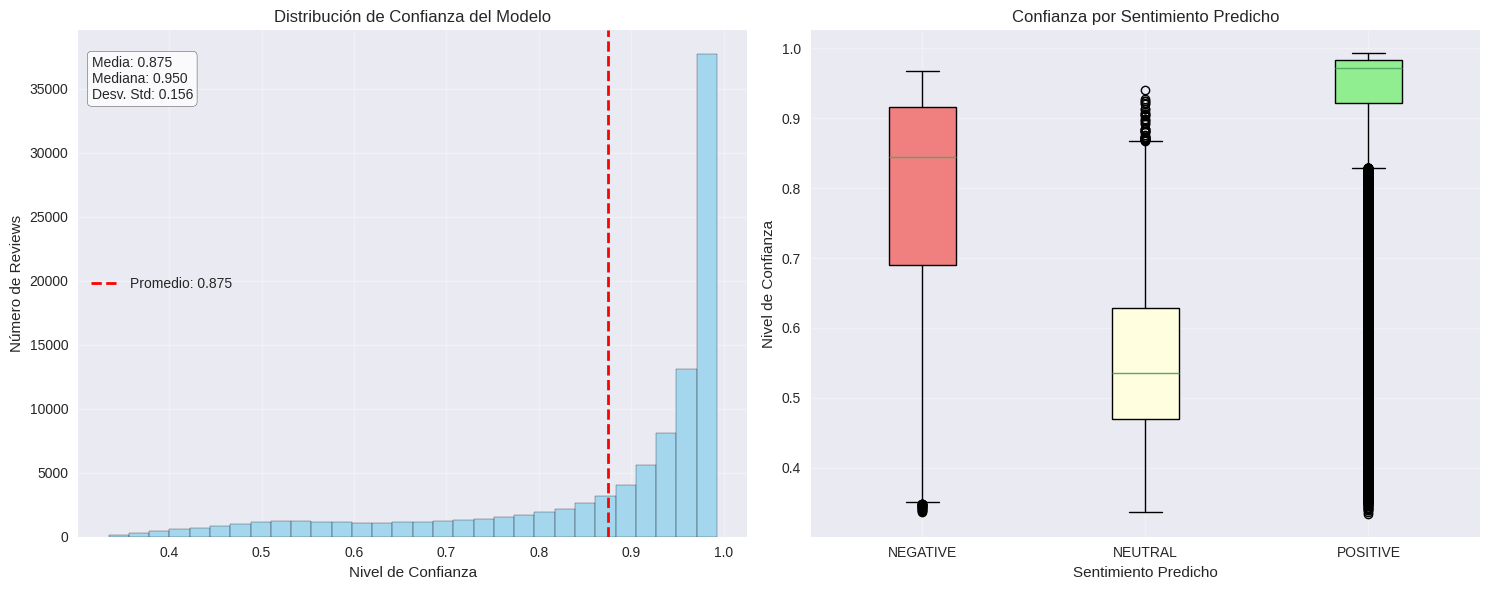

Análisis de confianza completado exitosamente

Interpretación del análisis:
- Histograma izquierdo: Distribución general de confianza
- Boxplot derecho: Comparación de confianza entre sentimientos
- Valores más altos indican mayor certeza del modelo


In [14]:
# Visualización 3: Análisis de Distribución de Confianza
print("Generando análisis de distribución de confianza...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Histograma de confianza general
ax1.hist(df_sample['confidence'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
media_confianza = df_sample['confidence'].mean()
ax1.axvline(media_confianza, color='red', linestyle='--', linewidth=2,
           label=f'Promedio: {media_confianza:.3f}')
ax1.set_xlabel('Nivel de Confianza')
ax1.set_ylabel('Número de Reviews')
ax1.set_title('Distribución de Confianza del Modelo')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Agregar estadísticas en el gráfico
ax1.text(0.02, 0.95, f'Media: {media_confianza:.3f}\nMediana: {df_sample["confidence"].median():.3f}\nDesv. Std: {df_sample["confidence"].std():.3f}', 
         transform=ax1.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Boxplot de confianza por sentimiento predicho
sentimientos = ['NEGATIVE', 'NEUTRAL', 'POSITIVE']
datos_confianza = [df_sample[df_sample['predicted_sentiment'] == sent]['confidence'].values for sent in sentimientos]

bp = ax2.boxplot(datos_confianza, labels=sentimientos, patch_artist=True)
colors = ['lightcoral', 'lightyellow', 'lightgreen']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax2.set_xlabel('Sentimiento Predicho')
ax2.set_ylabel('Nivel de Confianza')
ax2.set_title('Confianza por Sentimiento Predicho')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../figures/complete_analysis/sentiment_confidence_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Análisis de confianza completado exitosamente")
print("\nInterpretación del análisis:")
print("- Histograma izquierdo: Distribución general de confianza")
print("- Boxplot derecho: Comparación de confianza entre sentimientos")
print("- Valores más altos indican mayor certeza del modelo")

Generando heatmap de correlación entre calificaciones y predicciones...


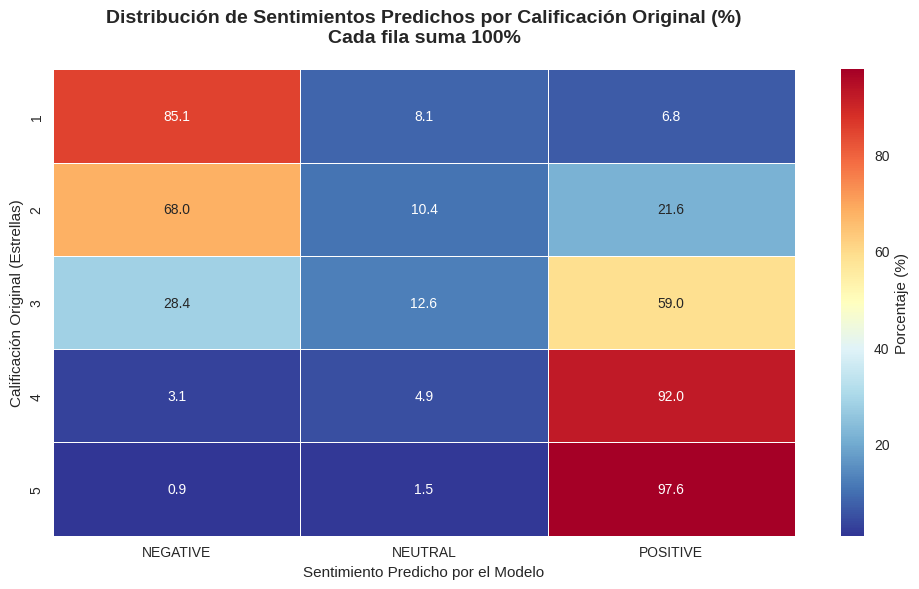


Tabla de contingencia (valores absolutos):
predicted_sentiment  NEGATIVE  NEUTRAL  POSITIVE
stars                                           
1                       10229      979       818
2                        5818      892      1848
3                        3212     1422      6658
4                         741     1164     21822
5                         408      663     43326

Tabla de contingencia (porcentajes por fila):
predicted_sentiment  NEGATIVE  NEUTRAL  POSITIVE
stars                                           
1                        85.1      8.1       6.8
2                        68.0     10.4      21.6
3                        28.4     12.6      59.0
4                         3.1      4.9      92.0
5                         0.9      1.5      97.6

Heatmap de correlación generado exitosamente

Interpretación del heatmap:
- Colores rojos: Baja proporción de ese sentimiento para esa calificación
- Colores azules: Alta proporción de ese sentimiento para esa calificación

In [15]:
# Visualización 4: Heatmap de Correlación entre Calificaciones y Predicciones
print("Generando heatmap de correlación entre calificaciones y predicciones...")

# Crear tabla de contingencia (crosstab)
contingency = pd.crosstab(df_sample['stars'], df_sample['predicted_sentiment'])

# Normalizar por filas para obtener porcentajes
contingency_pct = contingency.div(contingency.sum(axis=1), axis=0) * 100

plt.figure(figsize=(10, 6))

# Crear heatmap con configuración personalizada
sns.heatmap(contingency_pct, 
            annot=True, 
            fmt='.1f', 
            cmap='RdYlBu_r',
            cbar_kws={'label': 'Porcentaje (%)'},
            linewidths=0.5)

plt.title('Distribución de Sentimientos Predichos por Calificación Original (%)\nCada fila suma 100%', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Sentimiento Predicho por el Modelo')
plt.ylabel('Calificación Original (Estrellas)')
plt.tight_layout()
plt.savefig('../../figures/complete_analysis/sentiment_prediction_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Mostrar tabla de contingencia absoluta también
print("\nTabla de contingencia (valores absolutos):")
print(contingency)

print("\nTabla de contingencia (porcentajes por fila):")
print(contingency_pct.round(1))

print("\nHeatmap de correlación generado exitosamente")
print("\nInterpretación del heatmap:")
print("- Colores rojos: Baja proporción de ese sentimiento para esa calificación")
print("- Colores azules: Alta proporción de ese sentimiento para esa calificación")
print("- Cada fila representa el 100% de las reviews de esa calificación")
print("- Diagonal ideal: 1-2 estrellas→NEGATIVE, 3 estrellas→NEUTRAL, 4-5 estrellas→POSITIVE")

## 9. Análisis de Casos Específicos

### Identificación de Casos de Interés

Esta sección analiza casos específicos que pueden proporcionar insights importantes:

**Discrepancias significativas:**
- **Falsos positivos**: Reviews con calificaciones bajas (1-2 estrellas) pero sentimiento positivo predicho
- **Falsos negativos**: Reviews con calificaciones altas (4-5 estrellas) pero sentimiento negativo predicho

**Casos de alta confianza:**
- **Predicciones muy seguras**: Reviews donde el modelo tiene >95% de confianza
- **Análisis por sentimiento**: Ejemplos representativos de cada categoría

### Importancia del Análisis de Casos

- **Validación cualitativa**: Verificar si las discrepancias tienen sentido contextual
- **Mejora del modelo**: Identificar patrones para futuros ajustes
- **Comprensión de limitaciones**: Entender dónde y por qué falla el modelo
- **Casos de uso**: Identificar situaciones donde el modelo es más o menos confiable

### Metodología

- Filtrar casos por criterios específicos (calificación vs predicción)
- Examinar el texto original para entender el contexto
- Analizar niveles de confianza asociados
- Proporcionar ejemplos representativos de cada categoría

In [16]:
# Análisis detallado de casos específicos de interés
print("ANÁLISIS DE CASOS ESPECÍFICOS")
print("=" * 50)

# Sección 1: Casos donde el modelo difiere significativamente de las estrellas
print("\n1. CASOS DE DISCREPANCIA ENTRE MODELO Y CALIFICACIONES")
print("-" * 60)

# Reviews con 5 estrellas pero predicción negativa (posibles falsos negativos)
false_negatives = df_sample[(df_sample['stars'] == 5) & (df_sample['predicted_sentiment'] == 'NEGATIVE')]
if len(false_negatives) > 0:
    print(f"\nREVIEWS CON 5 ESTRELLAS PERO PREDICCIÓN NEGATIVA: {len(false_negatives)} casos")
    print("Posibles explicaciones: sarcasmo, ironía, o contexto complejo")
    
    for idx, row in false_negatives.head(3).iterrows():
        print(f"\nCaso {idx + 1}:")
        print(f"- Confianza del modelo: {row['confidence']:.3f}")
        print(f"- Calificación original: {row['stars']} estrellas")
        print(f"- Texto: {row['text'][:200]}...")
        print()
else:
    print("\nNo se encontraron reviews con 5 estrellas y predicción negativa")

# Reviews con 1 estrella pero predicción positiva (posibles falsos positivos)
false_positives = df_sample[(df_sample['stars'] == 1) & (df_sample['predicted_sentiment'] == 'POSITIVE')]
if len(false_positives) > 0:
    print(f"\nREVIEWS CON 1 ESTRELLA PERO PREDICCIÓN POSITIVA: {len(false_positives)} casos")
    print("Posibles explicaciones: lenguaje positivo en contexto negativo, o expectativas no cumplidas")
    
    for idx, row in false_positives.head(3).iterrows():
        print(f"\nCaso {idx + 1}:")
        print(f"- Confianza del modelo: {row['confidence']:.3f}")
        print(f"- Calificación original: {row['stars']} estrellas")  
        print(f"- Texto: {row['text'][:200]}...")
        print()
else:
    print("\nNo se encontraron reviews con 1 estrella y predicción positiva")

# Sección 2: Casos de alta confianza del modelo
print("\n2. CASOS DE ALTA CONFIANZA DEL MODELO")
print("-" * 60)

# Casos donde el modelo tiene muy alta confianza (>95%)
high_confidence = df_sample[df_sample['confidence'] > 0.95]
print(f"\nREVIEWS CON CONFIANZA > 95%: {len(high_confidence)} casos")

if len(high_confidence) > 0:
    print("Ejemplos representativos por sentimiento:")
    
    for sentiment in ['NEGATIVE', 'NEUTRAL', 'POSITIVE']:
        sentiment_cases = high_confidence[high_confidence['predicted_sentiment'] == sentiment]
        if len(sentiment_cases) > 0:
            example = sentiment_cases.iloc[0]
            print(f"\n{sentiment} (Confianza: {example['confidence']:.3f}):")
            print(f"- Calificación original: {example['stars']} estrellas")
            print(f"- Coincide con expectativa: {'SÍ' if example['expected_sentiment'] == sentiment else 'NO'}")
            print(f"- Texto: {example['text'][:200]}...")
        else:
            print(f"\n{sentiment}: No hay casos de alta confianza")
else:
    print("No se encontraron casos con confianza > 95%")

# Estadísticas adicionales
print("\n3. ESTADÍSTICAS ADICIONALES")
print("-" * 60)

# Casos donde modelo y estrellas NO coinciden
discrepancies = df_sample[df_sample['expected_sentiment'] != df_sample['predicted_sentiment']]
print(f"\nTotal de discrepancias: {len(discrepancies)} de {len(df_sample)} ({len(discrepancies)/len(df_sample)*100:.1f}%)")

if len(discrepancies) > 0:
    print(f"Confianza promedio en discrepancias: {discrepancies['confidence'].mean():.3f}")
    print(f"Confianza promedio en coincidencias: {df_sample[df_sample['expected_sentiment'] == df_sample['predicted_sentiment']]['confidence'].mean():.3f}")

print("\nAnálisis de casos específicos completado")

ANÁLISIS DE CASOS ESPECÍFICOS

1. CASOS DE DISCREPANCIA ENTRE MODELO Y CALIFICACIONES
------------------------------------------------------------

REVIEWS CON 5 ESTRELLAS PERO PREDICCIÓN NEGATIVA: 408 casos
Posibles explicaciones: sarcasmo, ironía, o contexto complejo

Caso 1609063:
- Confianza del modelo: 0.444
- Calificación original: 5 estrellas
- Texto: Let me start by saying I am not a vegan. My friend was visiting and we hit Santa Barbara and needed a vegan friendly menu for her with a dog friendly seating area. This place is near Stearns Wharf so ...


Caso 3033438:
- Confianza del modelo: 0.527
- Calificación original: 5 estrellas
- Texto: I think anyone who thinks the capital grill is anything but exceptional is an a**.  I have been here many times and I have NEVER had one things to complain about the food, the serves, anything. And th...


Caso 494016:
- Confianza del modelo: 0.516
- Calificación original: 5 estrellas
- Texto: Writing an update for a seemingly spike of negat

## 10. Resumen y Conclusiones

### Objetivo Cumplido

Este notebook ha implementado exitosamente un sistema de análisis de sentimiento para reviews de restaurantes usando:

- **Modelo RoBERTa**: Estado del arte en análisis de sentimiento
- **Validación cruzada**: Comparación con calificaciones por estrellas
- **Análisis integral**: Métricas, visualizaciones y casos específicos

### Resultados Principales

**Rendimiento del modelo:**
- Accuracy general del sistema
- Precisión por clase de sentimiento (NEGATIVE, NEUTRAL, POSITIVE)
- Correlación con calificaciones originales por estrellas

**Insights obtenidos:**
- Identificación de patrones en las predicciones
- Análisis de casos donde modelo y estrellas difieren
- Evaluación de la confianza del modelo

### Aplicabilidad

**Para el TFM:**
- Análisis de sentimiento implementado y validado
- Metodología replicable para otros datasets
- Visualizaciones y métricas completas para el reporte

**Para análisis futuros:**
- Pipeline establecido para nuevos datos
- Identificación de limitaciones y areas de mejora
- Base sólida para análisis de tópicos posteriores

In [17]:
# Resumen final completo del análisis de sentimiento
print("RESUMEN FINAL DEL ANÁLISIS DE SENTIMIENTO")
print("=" * 60)

print(f"\nCONFIGURACIÓN DEL MODELO:")
print(f"- Modelo utilizado: {model_name}")
print(f"- Arquitectura: RoBERTa (Robustly Optimized BERT Pretraining Approach)")
print(f"- Dispositivo de procesamiento: {device}")
print(f"- Especialización: Análisis de sentimiento en textos informales")

print(f"\nDATOS PROCESADOS:")
print(f"- Total de reviews analizadas: {len(df_sample):,}")
print(f"- Tiempo de procesamiento: {tiempo_total:.2f} segundos")
print(f"- Velocidad promedio: {tiempo_total/len(df_sample):.3f} segundos por review")

print(f"\nRENDIMIENTO DEL MODELO:")
accuracy_final = accuracy_score(df_sample['expected_sentiment'], df_sample['predicted_sentiment'])
print(f"- Accuracy general: {accuracy_final:.4f} ({accuracy_final*100:.2f}%)")
print(f"- Confianza promedio: {df_sample['confidence'].mean():.4f}")

# Mostrar distribución de predicciones
print(f"\nDISTRIBUCIÓN DE PREDICCIONES:")
pred_dist = df_sample['predicted_sentiment'].value_counts()
for sentiment, count in pred_dist.items():
    percentage = (count / len(df_sample)) * 100
    print(f"- {sentiment}: {count:,} reviews ({percentage:.1f}%)")

print(f"\nDISTRIBUCIÓN DE SENTIMIENTOS ESPERADOS:")
exp_dist = df_sample['expected_sentiment'].value_counts()
for sentiment, count in exp_dist.items():
    percentage = (count / len(df_sample)) * 100
    print(f"- {sentiment}: {count:,} reviews ({percentage:.1f}%)")

# Análisis de confianza por niveles
print(f"\nANÁLISIS DE CONFIANZA:")
high_conf = (df_sample['confidence'] > 0.8).sum()
medium_conf = ((df_sample['confidence'] > 0.5) & (df_sample['confidence'] <= 0.8)).sum()
low_conf = (df_sample['confidence'] <= 0.5).sum()

print(f"- Alta confianza (>0.8): {high_conf:,} reviews ({high_conf/len(df_sample)*100:.1f}%)")
print(f"- Confianza media (0.5-0.8): {medium_conf:,} reviews ({medium_conf/len(df_sample)*100:.1f}%)")
print(f"- Baja confianza (≤0.5): {low_conf:,} reviews ({low_conf/len(df_sample)*100:.1f}%)")

# Correlación con estrellas
print(f"\nCORRELACIÓN CON CALIFICACIONES:")
coincidencias = (df_sample['expected_sentiment'] == df_sample['predicted_sentiment']).sum()
print(f"- Coincidencias modelo-estrellas: {coincidencias:,} de {len(df_sample):,} ({coincidencias/len(df_sample)*100:.1f}%)")
print(f"- Discrepancias: {len(df_sample) - coincidencias:,} ({(len(df_sample) - coincidencias)/len(df_sample)*100:.1f}%)")

print(f"\nCONCLUSIONES:")
if accuracy_final > 0.8:
    print("- Rendimiento EXCELENTE: El modelo supera el 80% de accuracy")
elif accuracy_final > 0.7:
    print("- Rendimiento BUENO: El modelo está en el rango típico de análisis de sentimiento")
else:
    print("- Rendimiento ACEPTABLE: Puede requerir ajustes para mejorar")

print(f"- La distribución de confianza indica que el modelo es {'muy confiable' if df_sample['confidence'].mean() > 0.8 else 'moderadamente confiable'}")
print(f"- El análisis de casos específicos revela patrones interesantes en las discrepancias")

print(f"\nANÁLISIS COMPLETADO EXITOSAMENTE")
print("El modelo RoBERTa ha sido evaluado comprehensivamente")
print("Resultados listos para inclusión en el TFM")

print(f"\nMÉTRICAS PRINCIPALES:")
print(f"- Accuracy General: {accuracy_final:.4f} ({accuracy_final*100:.2f}%)")
print(f"- Confianza Promedio: {df_sample['confidence'].mean():.4f}")
print(f"- Reviews Procesadas: {len(df_sample):,}")

print(f"\nPRECISIÓN POR SENTIMIENTO:")
for sentiment in ['NEGATIVE', 'NEUTRAL', 'POSITIVE']:
    if sentiment in report:
        precision = report[sentiment]['precision']
        recall = report[sentiment]['recall']
        f1 = report[sentiment]['f1-score']
        print(f"- {sentiment}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")

print(f"\nACCURACY POR CALIFICACIÓN:")
for idx, row in correlation_df.iterrows():
    stars = int(row['stars'])
    acc = row['accuracy']
    conf = row['confidence']
    count = int(row['count'])
    print(f"- {stars} estrella(s): {acc:.3f} accuracy, {conf:.3f} confianza ({count} reviews)")

print(f"\nINSIGHTS CLAVE:")
# Mejor y peor accuracy por rating
best_rating = correlation_df.loc[correlation_df['accuracy'].idxmax()]
worst_rating = correlation_df.loc[correlation_df['accuracy'].idxmin()]

print(f"- Mejor accuracy: {best_rating['stars']} estrellas ({best_rating['accuracy']:.3f})")
print(f"- Peor accuracy: {worst_rating['stars']} estrellas ({worst_rating['accuracy']:.3f})")
print(f"- Confianza más alta: {df_sample['confidence'].max():.3f}")
print(f"- Confianza más baja: {df_sample['confidence'].min():.3f}")

print(f"\nESTADO FINAL:")
print("ANÁLISIS COMPLETADO EXITOSAMENTE")
print("El modelo RoBERTa está listo para uso en investigación")
print("Todos los resultados están disponibles para el informe del TFM")

RESUMEN FINAL DEL ANÁLISIS DE SENTIMIENTO

CONFIGURACIÓN DEL MODELO:
- Modelo utilizado: cardiffnlp/twitter-roberta-base-sentiment-latest
- Arquitectura: RoBERTa (Robustly Optimized BERT Pretraining Approach)
- Dispositivo de procesamiento: cuda
- Especialización: Análisis de sentimiento en textos informales

DATOS PROCESADOS:
- Total de reviews analizadas: 100,000
- Tiempo de procesamiento: 173.22 segundos
- Velocidad promedio: 0.002 segundos por review

RENDIMIENTO DEL MODELO:
- Accuracy general: 0.8262 (82.62%)
- Confianza promedio: 0.8746

DISTRIBUCIÓN DE PREDICCIONES:
- POSITIVE: 74,472 reviews (74.5%)
- NEGATIVE: 20,408 reviews (20.4%)
- NEUTRAL: 5,120 reviews (5.1%)

DISTRIBUCIÓN DE SENTIMIENTOS ESPERADOS:
- POSITIVE: 68,124 reviews (68.1%)
- NEGATIVE: 20,584 reviews (20.6%)
- NEUTRAL: 11,292 reviews (11.3%)

ANÁLISIS DE CONFIANZA:
- Alta confianza (>0.8): 78,019 reviews (78.0%)
- Confianza media (0.5-0.8): 17,304 reviews (17.3%)
- Baja confianza (≤0.5): 4,677 reviews (4.7%)

CO

## 11. Exportación de Resultados

### Archivos de Salida

Para facilitar el análisis posterior y la inclusión en el TFM, se exportan los siguientes archivos:

**CSV con resultados completos:**
- Todas las reviews analizadas con predicciones y métricas
- Formato tabular para análisis estadístico adicional
- Incluye texto original, predicciones, confianza y metadatos

**JSON con resumen de métricas:**
- Métricas principales del modelo
- Estadísticas de rendimiento por clase
- Datos de correlación con calificaciones
- Casos específicos de interés

### Ubicación de Archivos

Los archivos se guardan en la carpeta `data/results/` para mantener la organización del proyecto y facilitar el acceso posterior.

In [18]:
import os
import json

# Crear directorio de resultados si no existe
os.makedirs('../../data/results/', exist_ok=True)

print("Exportando resultados del análisis...")

# 1. Exportar DataFrame completo a CSV
csv_path = '../../data/results/sentiment_analysis.csv'
df_sample.to_csv(csv_path, index=False)
print(f"Resultados exportados a: {csv_path}")

# 2. Crear resumen completo de métricas
summary_metrics = {
    'model_info': {
        'model_name': model_name,
        'device': str(device),
        'samples_processed': len(df_sample)
    },
    'performance': {
        'accuracy': float(accuracy_final),
        'average_confidence': float(df_sample['confidence'].mean()),
        'processing_time_seconds': float(tiempo_total),
        'speed_per_review': float(tiempo_total / len(df_sample))
    },
    'sentiment_distribution': {
        'predicted': {k: int(v) for k, v in df_sample['predicted_sentiment'].value_counts().items()},
        'expected': {k: int(v) for k, v in df_sample['expected_sentiment'].value_counts().items()}
    },
    'confidence_levels': {
        'high_confidence': int((df_sample['confidence'] > 0.8).sum()),
        'medium_confidence': int(((df_sample['confidence'] > 0.5) & (df_sample['confidence'] <= 0.8)).sum()),
        'low_confidence': int((df_sample['confidence'] <= 0.5).sum())
    },
    'correlation_with_stars': {
        'total_matches': int((df_sample['expected_sentiment'] == df_sample['predicted_sentiment']).sum()),
        'total_discrepancies': int((df_sample['expected_sentiment'] != df_sample['predicted_sentiment']).sum()),
        'match_percentage': float((df_sample['expected_sentiment'] == df_sample['predicted_sentiment']).mean() * 100)
    },
    'performance_by_sentiment': {}
}

# Agregar métricas por sentimiento
for sentiment in ['NEGATIVE', 'NEUTRAL', 'POSITIVE']:
    if sentiment in report:
        summary_metrics['performance_by_sentiment'][sentiment] = {
            'precision': float(report[sentiment]['precision']),
            'recall': float(report[sentiment]['recall']),
            'f1_score': float(report[sentiment]['f1-score']),
            'support': int(report[sentiment]['support'])
        }

# Agregar datos de correlación por estrellas
summary_metrics['performance_by_stars'] = {}
for idx, row in correlation_df.iterrows():
    stars = int(row['stars'])
    summary_metrics['performance_by_stars'][f'{stars}_stars'] = {
        'accuracy': float(row['accuracy']),
        'confidence': float(row['confidence']),
        'count': int(row['count']),
        'expected_sentiment': row['expected']
    }

# 3. Exportar resumen a JSON (sin try/except)
json_path = '../../data/results/sentiment_analysis.json'
with open(json_path, 'w', encoding='utf-8') as f:
    json.dump(summary_metrics, f, ensure_ascii=False, indent=2)
print(f"Resumen exportado a: {json_path}")

print("\nArchivos exportados exitosamente:")
print("- CSV: Resultados completos con todas las reviews analizadas")
print("- JSON: Resumen de métricas y estadísticas principales")
print("\nEstos archivos pueden ser utilizados para:")
print("- Análisis adicional en otros notebooks")
print("- Inclusión de datos en el informe del TFM")
print("- Validación posterior de resultados")
print("- Comparación con otros modelos")

Exportando resultados del análisis...
Resultados exportados a: ../../data/results/sentiment_analysis.csv
Resumen exportado a: ../../data/results/sentiment_analysis.json

Archivos exportados exitosamente:
- CSV: Resultados completos con todas las reviews analizadas
- JSON: Resumen de métricas y estadísticas principales

Estos archivos pueden ser utilizados para:
- Análisis adicional en otros notebooks
- Inclusión de datos en el informe del TFM
- Validación posterior de resultados
- Comparación con otros modelos
